In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

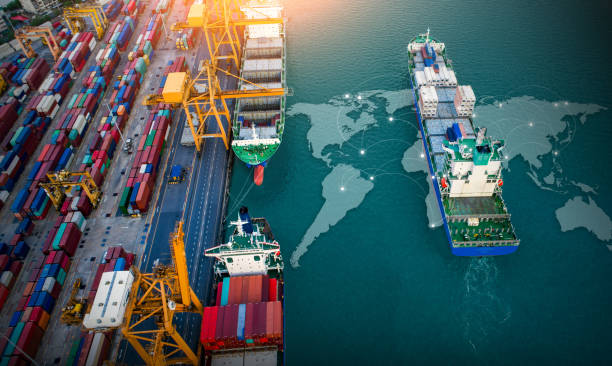

# Objective

According to the Supply Chain Stability Index, the Supply Chain Stability Index measures the stability of supply chain procedures within an organization. As of 2024, the index survey has found that logistics accounts for 71% of supply chain stress. 

As organizations continue to manage their supply chain risk. Within this analysis, I will thoroughly explore the logistics of the USAID - Bureau for Global Health and provide recommendations on improving their supply chain of medical needs across the global market. 

**Data Acknowledgement**: The dataset was sourced from the USAID - Bureau for Global Health.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Load the Supply_Chain_Shipment_Data.csv file into a DataFrame
file_path = '/kaggle/input/supply-chain-shipment-dataset/Suppy_Chain_Shipment_Data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
print(df.head())

   id project code            pq # po / so # asn/dn #        country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  managed by  fulfill via vendor inco term shipment mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  unit of measure (per pack) line item quantity line item value pack price  \
0                         30                 19           551.0      29.00   
1                   

# I. Data Cleaning

In [4]:
# Load the data
df = pd.read_csv('/kaggle/input/supply-chain-shipment-dataset/Suppy_Chain_Shipment_Data.csv')

# Identify null values
null_counts = df.isnull().sum()

# Identify missing values (including 'None' and empty strings)
missing_counts = df.isna().sum() + (df == 'None').sum() + (df == '').sum()

# Identify duplicates
duplicate_count = df.duplicated().sum()

In [5]:
# Display data types of each column
print(df.dtypes)

# Display unique values in 'shipment mode' and 'dosage' columns
print("\
Unique values in 'shipment mode':")
print(df['shipment mode'].unique())

print("\
Unique values in 'dosage':")
print(df['dosage'].unique())

# Count of null values
print("\
Null value counts:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Count of 'None' values
print("\
'None' value counts:")
print((df == 'None').sum()[(df == 'None').sum() > 0])

# Count of empty strings
print("\
Empty string counts:")
print((df == '').sum()[(df == '').sum() > 0])

id                                int64
project code                     object
pq #                             object
po / so #                        object
asn/dn #                         object
country                          object
managed by                       object
fulfill via                      object
vendor inco term                 object
shipment mode                    object
pq first sent to client date     object
po sent to vendor date           object
scheduled delivery date          object
delivered to client date         object
delivery recorded date           object
product group                    object
sub classification               object
vendor                           object
item description                 object
molecule/test type               object
brand                            object
dosage                           object
dosage form                      object
unit of measure (per pack)        int64
line item quantity                int64


In [6]:
# Handle non-numeric data when replacing null values with the median'
# For 'shipment mode' and 'dosage', I will replace nulls with the most frequent value (mode)

# Replace nulls in 'shipment mode' with mode
shipment_mode_mode = df['shipment mode'].mode()[0]
df['shipment mode'].fillna(shipment_mode_mode, inplace=True)

# Replace nulls in 'dosage' with mode
dosage_mode = df['dosage'].mode()[0]
df['dosage'].fillna(dosage_mode, inplace=True)

# Replace nulls in 'line item insurance (usd)' with median
line_item_insurance_median = df['line item insurance (usd)'].median()
df['line item insurance (usd)'].fillna(line_item_insurance_median, inplace=True)

# Remove duplicate rows
df_cleaned = df.drop_duplicates()

# Replace missing values (empty strings and 'None') with the median or mode
for column in df_cleaned.columns:
    if df[column].dtype == 'object':
        # For object columns, replace with mode
        mode_value = df_cleaned[column].mode()[0]
        df[column].replace({'': mode_value, 'None': mode_value}, inplace=True)
    else:
        # For numeric columns, replace with median
        median_value = df_cleaned[column].median()
        df_cleaned[column].replace({'': median_value, 'None': median_value}, inplace=True)

# Describe the cleaned dataset
print("Head of the cleaned dataset:")
print(df_cleaned.head())

print("\
Tail of the cleaned dataset:")
print(df_cleaned.tail())

print("\
Dataset information:")
df_cleaned.info()

print("\
Summary statistics of numeric columns:")
print(df_cleaned.describe())

print("Null values replaced with mode or median where appropriate.")

/tmp/ipykernel_17/2599639041.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['shipment mode'].fillna(shipment_mode_mode, inplace=True)
/tmp/ipykernel_17/2599639041.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Head of the cleaned dataset:
   id project code            pq # po / so # asn/dn #        country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  managed by  fulfill via vendor inco term shipment mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  unit of measure (per pack) line item quantity line item value pack price  \
0                         30                 19           551.0      

# II. Exploratory Data Analysis

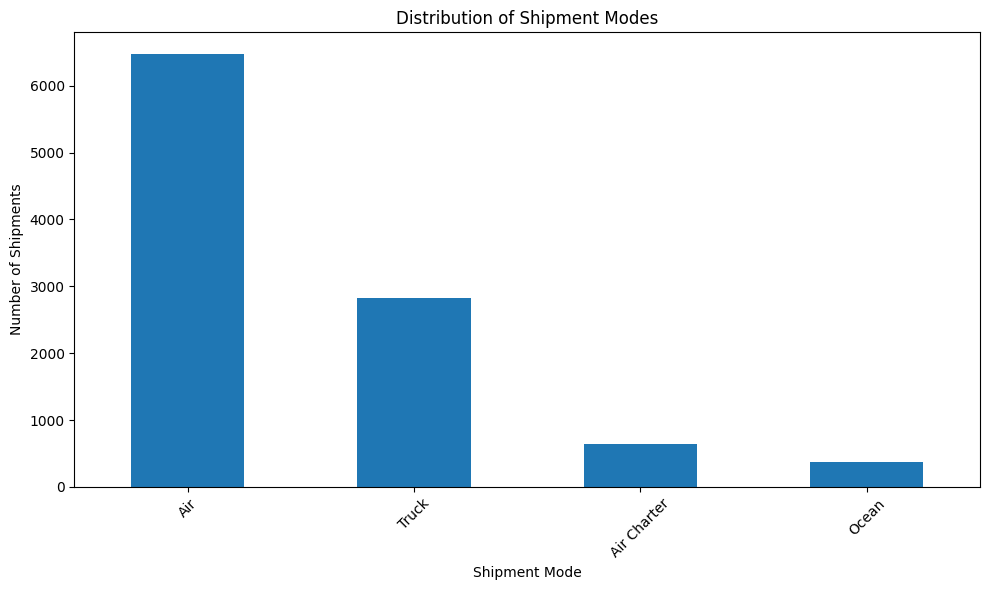

Shipment Mode Analysis:
               Frequency  Percentage
shipment mode                       
Air                 6473   62.698566
Truck               2830   27.411856
Air Charter          650    6.296009
Ocean                371    3.593568


In [7]:
# Analyze shipment modes
plt.figure(figsize=(10, 6))
df_cleaned['shipment mode'].value_counts().plot(kind='bar')
plt.title('Distribution of Shipment Modes')
plt.xlabel('Shipment Mode')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the frequency and percentage of each shipment mode
shipment_mode_stats = df_cleaned['shipment mode'].value_counts()
shipment_mode_percentage = df_cleaned['shipment mode'].value_counts(normalize=True) * 100

shipment_mode_analysis = pd.DataFrame({
    'Frequency': shipment_mode_stats,
    'Percentage': shipment_mode_percentage
})

print("Shipment Mode Analysis:")
print(shipment_mode_analysis)

# IIa. Key Observations:

* Air is the most common shipment mode, accounting for approximately 62.7% of shipments.

* Truck is the second most common mode, with 27.4% of shipments.

* Air Charter and Ocean are less frequently used, with 6.3% and 3.6% of shipments, respectively.

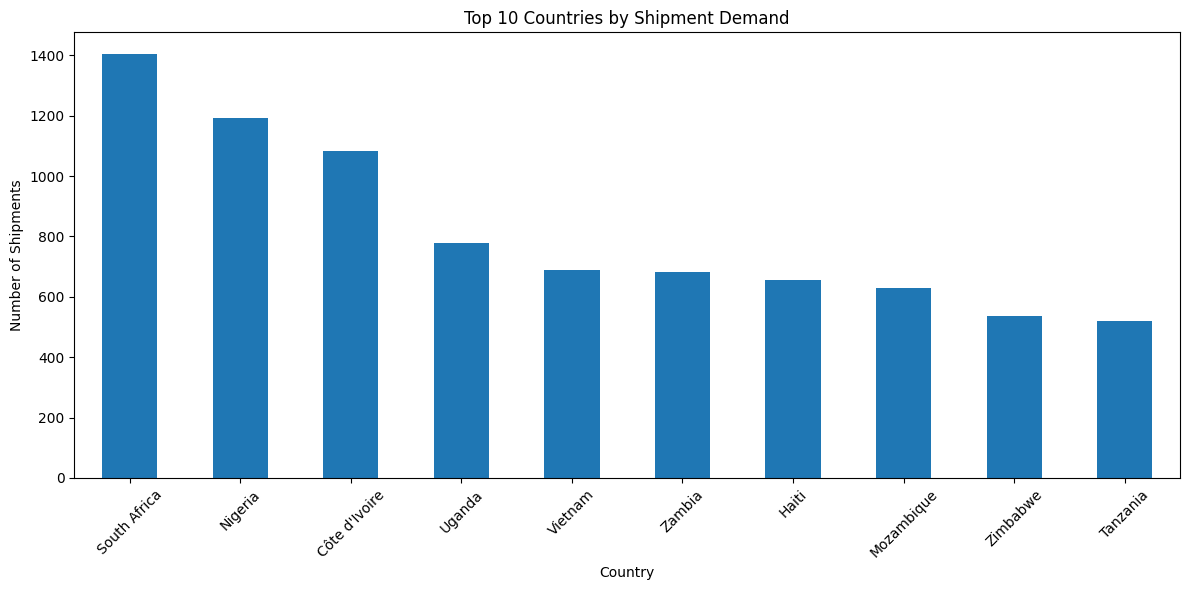

Top 10 Countries by Shipment Demand:
country
South Africa     1406
Nigeria          1194
Côte d'Ivoire    1083
Uganda            779
Vietnam           688
Zambia            683
Haiti             655
Mozambique        631
Zimbabwe          538
Tanzania          519
Name: count, dtype: int64


In [8]:
# Analyze top 10 countries by shipment demand
plt.figure(figsize=(12, 6))
df_cleaned['country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by Shipment Demand')
plt.xlabel('Country')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the top 10 countries by shipment demand
top_10_countries = df_cleaned['country'].value_counts().head(10)

print("Top 10 Countries by Shipment Demand:")
print(top_10_countries)

# IIb. Key Observations:

* South Africa leads with the highest number of shipments (1,406), followed by Nigeria (1,194) and Côte d'Ivoire (1,083).
 
* The top 10 countries show a focus on African nations, with Vietnam and Haiti being the two non-African countries on the list.

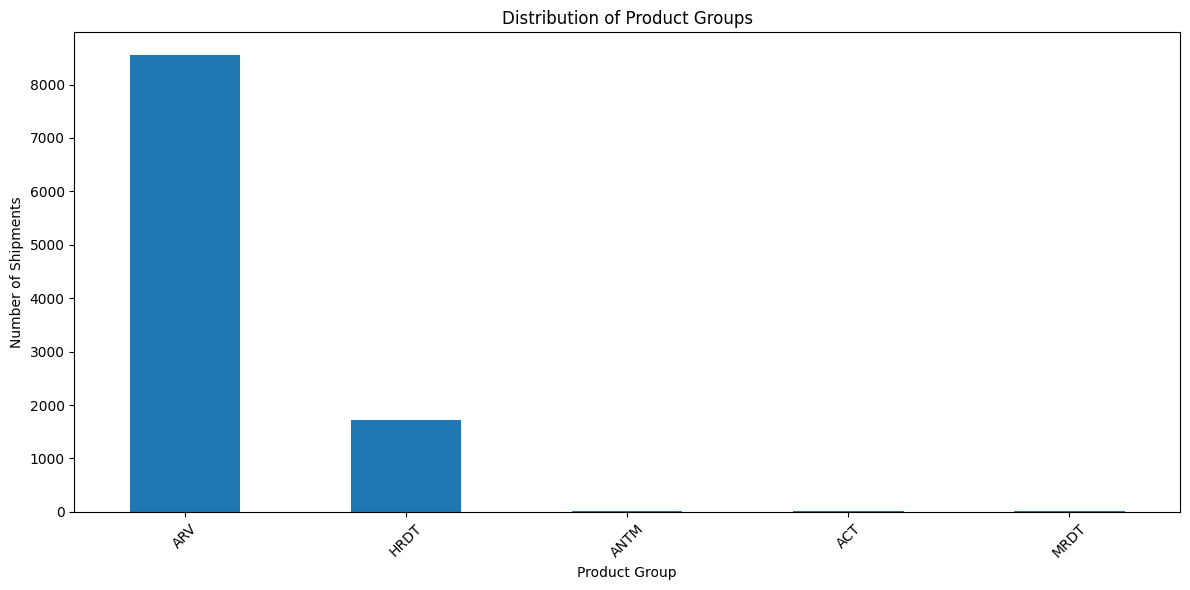

Product Group Analysis:
               Frequency  Percentage
product group                       
ARV                 8550   82.816738
HRDT                1728   16.737699
ANTM                  22    0.213096
ACT                   16    0.154979
MRDT                   8    0.077489


In [9]:
# Analyze the distribution of product groups
plt.figure(figsize=(12, 6))
df_cleaned['product group'].value_counts().plot(kind='bar')
plt.title('Distribution of Product Groups')
plt.xlabel('Product Group')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the frequency and percentage of each product group
product_group_stats = df_cleaned['product group'].value_counts()
product_group_percentage = df_cleaned['product group'].value_counts(normalize=True) * 100

product_group_analysis = pd.DataFrame({
    'Frequency': product_group_stats,
    'Percentage': product_group_percentage
})

print("Product Group Analysis:")
print(product_group_analysis)

# IIc. Key Observations: 

* ARV (Antiretroviral) products dominate the shipments, accounting for 82.8% of total shipments.

* HRDT (HIV Rapid Diagnostic Test) is the second most common product group, making up 16.7% of shipments.

* Other product groups (ANTM, ACT, MRDT) collectively account for less than 1% of shipments.

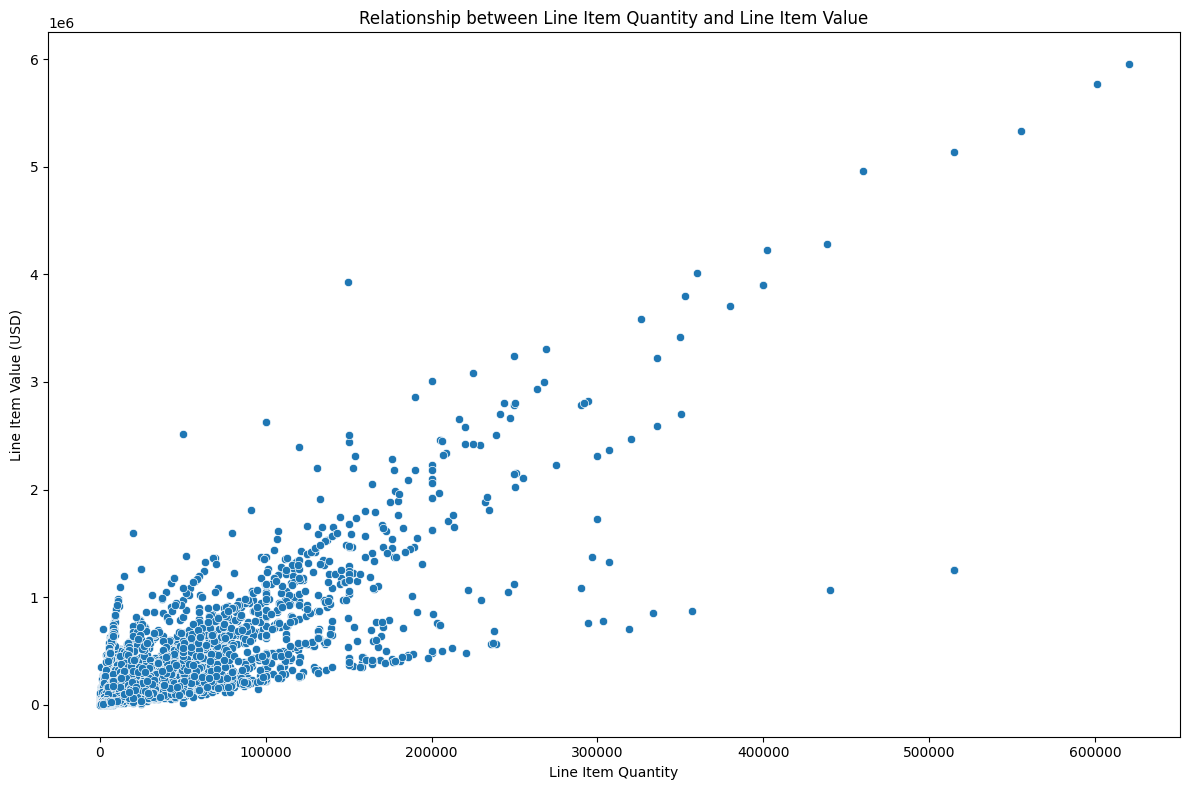

Correlation between Line Item Quantity and Line Item Value: 0.8391
Summary of Line Item Value for top 10 Line Item Quantities:
      line item quantity        mean      median         min         max
5064              619999  5951990.40  5951990.40  5951990.40  5951990.40
5063              600906  5768697.60  5768697.60  5768697.60  5768697.60
5062              555197  5329891.20  5329891.20  5329891.20  5329891.20
5061              515000  1251450.00  1251450.00  1251450.00  1251450.00
5060              514526  5140114.74  5140114.74  5140114.74  5140114.74
5059              460041  4959241.98  4959241.98  4959241.98  4959241.98
5058              440000  1069200.00  1069200.00  1069200.00  1069200.00
5057              438409  4278871.84  4278871.84  4278871.84  4278871.84
5056              401961  4228629.72  4228629.72  4228629.72  4228629.72
5055              400000  3904000.00  3904000.00  3904000.00  3904000.00


In [10]:
# Scatter plot of line item quantity vs. line item value
plt.figure(figsize=(12, 8))
sns.scatterplot(x='line item quantity', y='line item value', data=df_cleaned)
plt.title('Relationship between Line Item Quantity and Line Item Value')
plt.xlabel('Line Item Quantity')
plt.ylabel('Line Item Value (USD)')
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_cleaned['line item quantity'].corr(df_cleaned['line item value'])

print(f"Correlation between Line Item Quantity and Line Item Value: {correlation:.4f}")

# Summary of the relationship
summary = df_cleaned.groupby('line item quantity')['line item value'].agg(['mean', 'median', 'min', 'max']).reset_index()
summary = summary.sort_values('line item quantity', ascending=False).head(10)

print("\
Summary of Line Item Value for top 10 Line Item Quantities:")
print(summary)

# IId. Key Observations:

There is a strong positive correlation (0.8391) between line item quantity and line item value.

As the quantity increases, the line item value tends to increase as well.

The relationship appears to be roughly linear, but with some variation.

There are some outliers with very high quantities and values, which could represent bulk orders or high-value items.

The top 10 line item quantities show a wide range of values, from around 1 million to nearly 6 million USD.

/tmp/ipykernel_17/1949036636.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_17/1949036636.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_gdf['centroid'] = country_gdf.centroid
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipyker

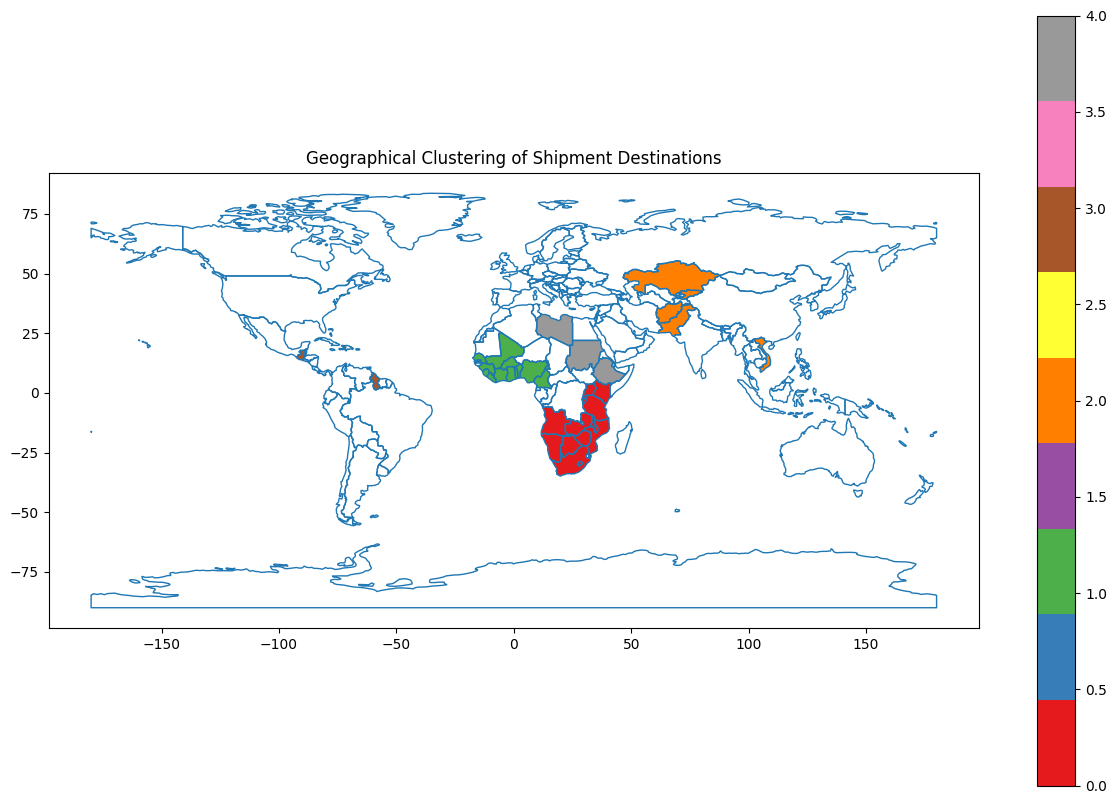

In [11]:
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract unique countries from the dataset
countries = df_cleaned['country'].unique()

# Create a GeoDataFrame for the countries
country_gdf = world[world['name'].isin(countries)]

# Calculate centroids for clustering
country_gdf['centroid'] = country_gdf.centroid
country_gdf['x'] = country_gdf.centroid.x
country_gdf['y'] = country_gdf.centroid.y

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)
country_gdf['cluster'] = kmeans.fit_predict(country_gdf[['x', 'y']])

# Plot the clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
country_gdf.plot(column='cluster', ax=ax, legend=True, cmap='Set1')
plt.title('Geographical Clustering of Shipment Destinations')
plt.show()

# III. Descriptive Analysis

# IIIa. Cost-Benefit Analysis

In [12]:
# Summary statistics of numeric columns
summary_stats = df_cleaned.describe()

# Count of unique values in categorical columns
unique_counts = df_cleaned.select_dtypes(include=['object']).nunique()

# Display the results
print("Summary statistics of numeric columns:")
print(summary_stats)

print("\
Count of unique values in categorical columns:")
print(unique_counts)

Summary statistics of numeric columns:
                 id  unit of measure (per pack)  line item quantity  \
count  10324.000000                10324.000000        10324.000000   
mean   51098.968229                   77.990895        18332.534870   
std    31944.332496                   76.579764        40035.302961   
min        1.000000                    1.000000            1.000000   
25%    12795.750000                   30.000000          408.000000   
50%    57540.500000                   60.000000         3000.000000   
75%    83648.250000                   90.000000        17039.750000   
max    86823.000000                 1000.000000       619999.000000   

       line item value    pack price    unit price  line item insurance (usd)  
count     1.032400e+04  10324.000000  10324.000000               10324.000000  
mean      1.576506e+05     21.910241      0.611701                 234.750202  
std       3.452921e+05     45.609223      3.275808                 494.208887  
m

Cost analysis by shipment mode:
  shipment mode  line item value  freight cost (usd)  \
1   Air Charter    379034.201769        21052.142642   
2         Ocean    340102.274367        12733.080816   
3         Truck    207555.607456        10176.405000   
0           Air    103144.123783        10271.688375   

   line item insurance (usd)     total_cost  cost_per_dollar  
1                 543.556585  400629.900995         0.056976  
2                 567.808518  353403.163700         0.039108  
3                 294.259442  218026.271898         0.050448  
0                 158.634038  113574.446197         0.101124  


<Figure size 1200x600 with 0 Axes>

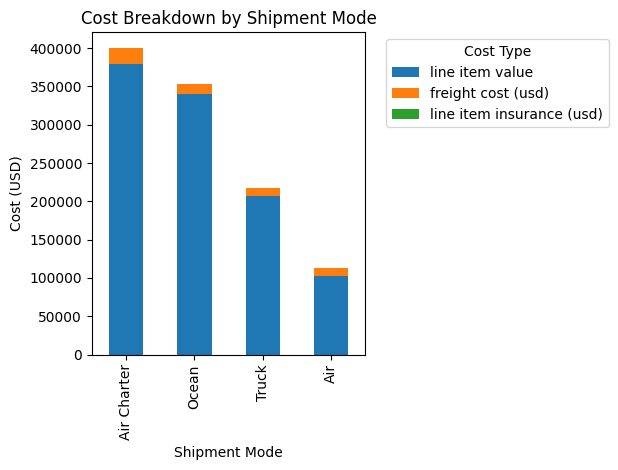

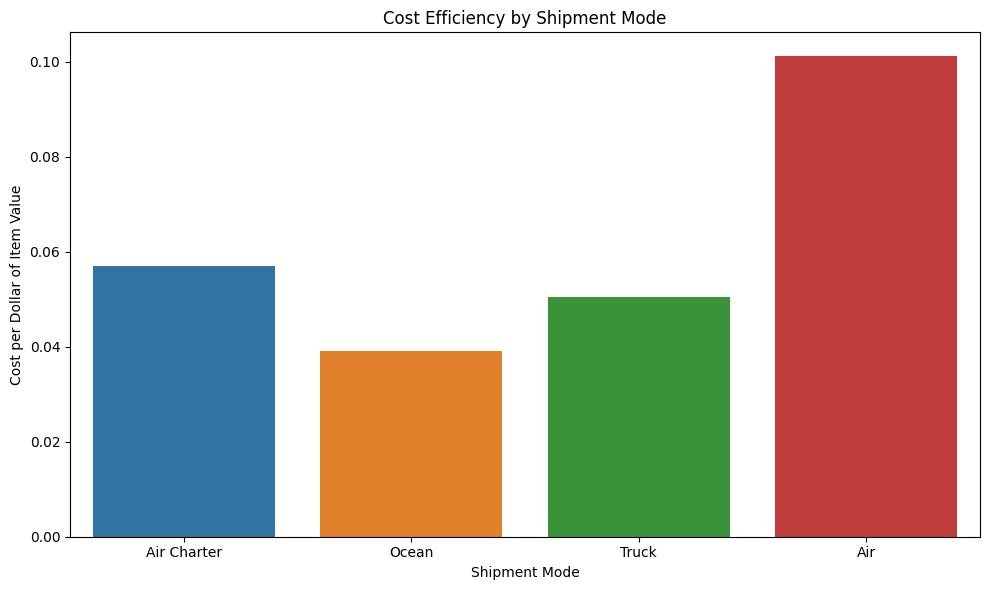

In [13]:
# Convert columns to numeric, coercing errors to NaN
numeric_columns = ['line item value', 'freight cost (usd)', 'line item insurance (usd)']
for col in numeric_columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Group by shipment mode and calculate average costs
cost_analysis = df_cleaned.groupby('shipment mode').agg({
    'line item value': 'mean',
    'freight cost (usd)': 'mean',
    'line item insurance (usd)': 'mean'
}).reset_index()

# Calculate total cost
cost_analysis['total_cost'] = cost_analysis['line item value'] + cost_analysis['freight cost (usd)'] + cost_analysis['line item insurance (usd)']

# Calculate cost per dollar of item value
cost_analysis['cost_per_dollar'] = (cost_analysis['freight cost (usd)'] + cost_analysis['line item insurance (usd)']) / cost_analysis['line item value']

# Sort by total cost
cost_analysis = cost_analysis.sort_values('total_cost', ascending=False)

# Display the results
print("Cost analysis by shipment mode:")
print(cost_analysis)

# Visualize the cost breakdown
plt.figure(figsize=(12, 6))
cost_analysis.set_index('shipment mode')[['line item value', 'freight cost (usd)', 'line item insurance (usd)']].plot(kind='bar', stacked=True)
plt.title('Cost Breakdown by Shipment Mode')
plt.xlabel('Shipment Mode')
plt.ylabel('Cost (USD)')
plt.legend(title='Cost Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize the cost efficiency
plt.figure(figsize=(10, 6))
sns.barplot(x='shipment mode', y='cost_per_dollar', data=cost_analysis)
plt.title('Cost Efficiency by Shipment Mode')
plt.xlabel('Shipment Mode')
plt.ylabel('Cost per Dollar of Item Value')
plt.tight_layout()
plt.show()

# IIIa1. Key Observations:

* Air Charter has the highest total cost but a moderate cost per dollar of item value.

* Ocean shipments have a lower total cost and the lowest cost per dollar of item value, making it the most cost-efficient mode.

* Truck shipments have a moderate total cost and cost efficiency.

* Air shipments have the lowest total cost but the highest cost per dollar of item value, indicating less cost efficiency.

# IV. Freight Cost Analysis

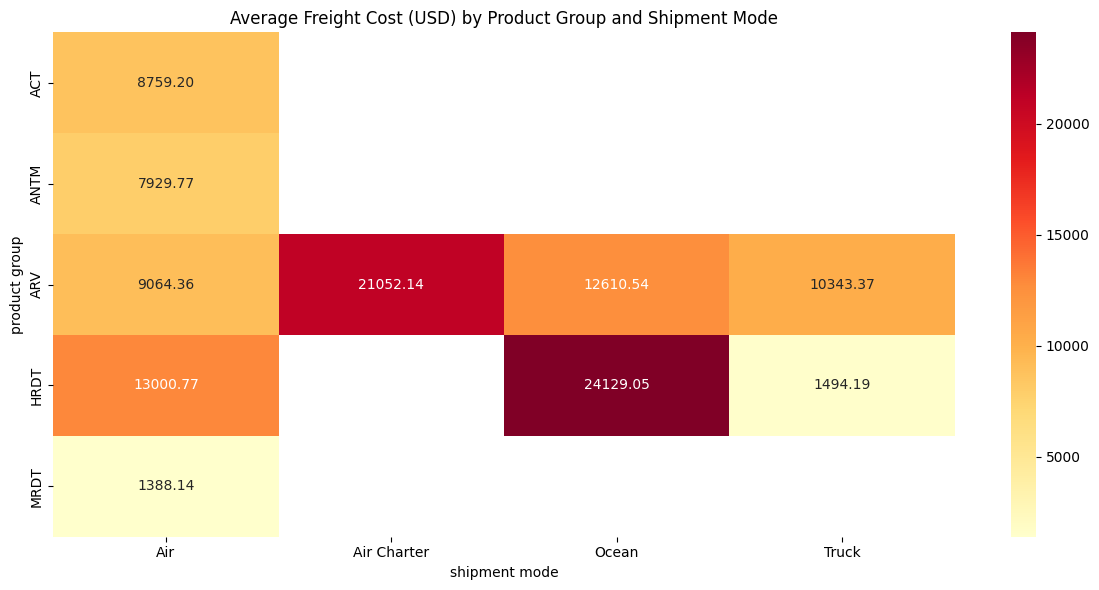

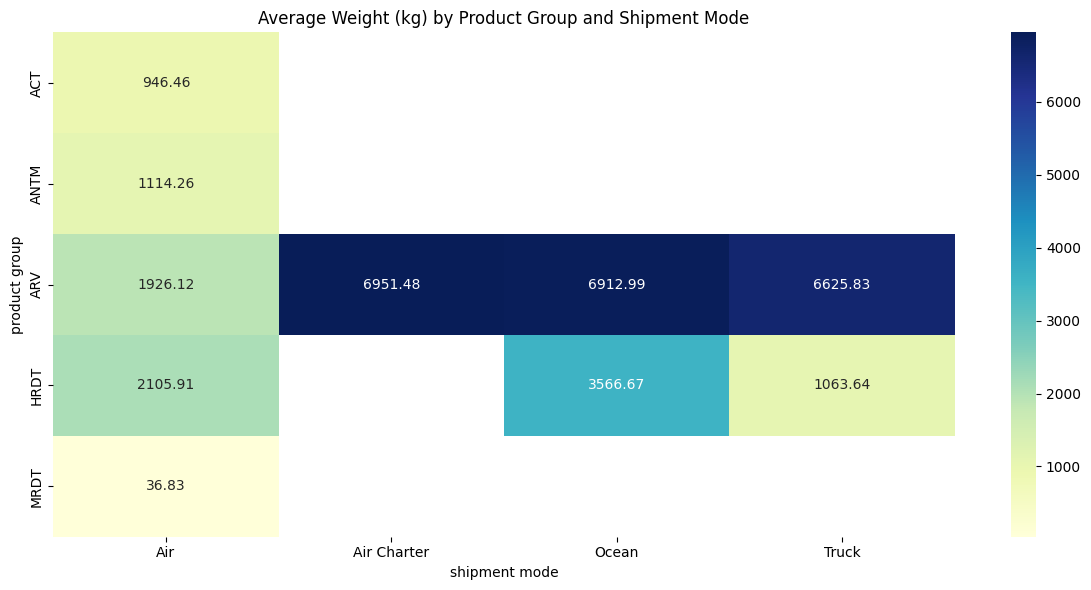

Average Freight Cost (USD) by Product Group and Shipment Mode:
shipment mode           Air   Air Charter         Ocean         Truck
product group                                                        
ACT             8759.196154           NaN           NaN           NaN
ANTM            7929.770526           NaN           NaN           NaN
ARV             9064.362385  21052.142642  12610.543477  10343.370726
HRDT           13000.774253           NaN  24129.053333   1494.187273
MRDT            1388.141667           NaN           NaN           NaN
Average Weight (kg) by Product Group and Shipment Mode:
shipment mode          Air  Air Charter        Ocean        Truck
product group                                                    
ACT             946.461538          NaN          NaN          NaN
ANTM           1114.263158          NaN          NaN          NaN
ARV            1926.119987  6951.479675  6912.985663  6625.828914
HRDT           2105.913462          NaN  3566.666667  1063.63

In [14]:
# Convert 'weight (kilograms)' and 'freight cost (usd)' to numeric, coercing errors to NaN
df_cleaned['weight (kilograms)'] = pd.to_numeric(df_cleaned['weight (kilograms)'], errors='coerce')
df_cleaned['freight cost (usd)'] = pd.to_numeric(df_cleaned['freight cost (usd)'], errors='coerce')

# Group by product group and shipment mode
grouped = df_cleaned.groupby(['product group', 'shipment mode'])

# Calculate average freight cost and weight
avg_freight_weight = grouped.agg({
    'freight cost (usd)': 'mean',
    'weight (kilograms)': 'mean'
}).reset_index()

# Pivot the data for easier plotting
pivot_freight = avg_freight_weight.pivot(index='product group', columns='shipment mode', values='freight cost (usd)')
pivot_weight = avg_freight_weight.pivot(index='product group', columns='shipment mode', values='weight (kilograms)')

# Plot freight cost
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_freight, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Freight Cost (USD) by Product Group and Shipment Mode')
plt.tight_layout()
plt.show()

# Plot weight
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_weight, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Average Weight (kg) by Product Group and Shipment Mode')
plt.tight_layout()
plt.show()

print("Average Freight Cost (USD) by Product Group and Shipment Mode:")
print(pivot_freight)
print("\
Average Weight (kg) by Product Group and Shipment Mode:")
print(pivot_weight)

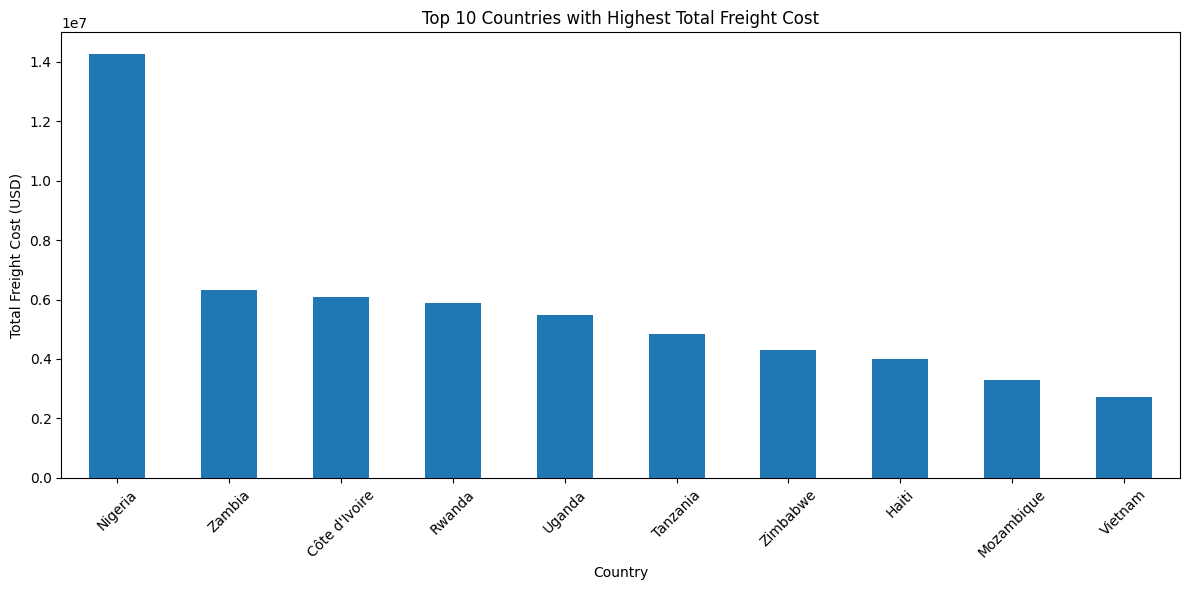

Top 10 Countries with Highest Total Freight Cost:
country
Nigeria          14268550.39
Zambia            6310437.21
Côte d'Ivoire     6092165.51
Rwanda            5893493.23
Uganda            5484292.24
Tanzania          4827989.32
Zimbabwe          4318000.86
Haiti             4000498.93
Mozambique        3294121.06
Vietnam           2737277.29
Name: freight cost (usd), dtype: float64
Average Freight Cost and Weight per Shipment for Top 10 Countries:
               freight cost (usd)  weight (kilograms)
country                                              
Nigeria              18676.113076         4616.527964
Rwanda               16838.552086         2663.665730
Zimbabwe             13536.052853         5172.515337
Zambia               12205.874681         6911.190207
Tanzania             11718.420680         3364.737470
Haiti                10102.270025         1503.556962
Uganda                9723.922411         2252.278947
Mozambique            9024.989205         6440.900804
Côte

In [15]:
# Group by country and calculate total freight cost
country_freight_cost = df_cleaned.groupby('country')['freight cost (usd)'].sum().sort_values(ascending=False)

# Get the top 10 countries
top_10_countries = country_freight_cost.head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
top_10_countries.plot(kind='bar')
plt.title('Top 10 Countries with Highest Total Freight Cost')
plt.xlabel('Country')
plt.ylabel('Total Freight Cost (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top 10 Countries with Highest Total Freight Cost:")
print(top_10_countries)

# Calculate average freight cost per shipment for these countries
top_10_avg_freight = df_cleaned[df_cleaned['country'].isin(top_10_countries.index)].groupby('country').agg({
    'freight cost (usd)': 'mean',
    'weight (kilograms)': 'mean'
}).sort_values('freight cost (usd)', ascending=False)

print("\
Average Freight Cost and Weight per Shipment for Top 10 Countries:")
print(top_10_avg_freight)

# IVa. Key Observation:

* Nigeria has the highest total freight cost, followed by Zambia and Côte d'Ivoire.

* The average freight cost per shipment is highest in Nigeria, with an average weight of 4,616.53 kg per shipment.

* Rwanda and Zimbabwe also have high average freight costs per shipment, with significant average weights.

* Vietnam has the lowest average freight cost and weight per shipment among the top 10 countries.

# V. On-Time Analysis

In [16]:
# Convert date columns to datetime
date_columns = ['scheduled delivery date', 'delivered to client date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate on-time delivery
df['on_time'] = df['delivered to client date'] <= df['scheduled delivery date']

# Calculate on-time delivery percentage for each country
country_performance = df.groupby('country')['on_time'].mean().sort_values(ascending=False)

# Display the first few rows of the dataset and the country performance
print(df.head())
print("\
On-time delivery performance by country:")
print(country_performance)

# Calculate overall on-time delivery percentage
overall_on_time = df['on_time'].mean()
print(f"\
Overall on-time delivery percentage: {overall_on_time:.2%}")

/tmp/ipykernel_17/3785988509.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_17/3785988509.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


   id project code            pq # po / so # asn/dn #        country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
3  15   108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam   
4  16   108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam   

  managed by  fulfill via vendor inco term shipment mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
3   PMO - US  Direct Drop              EXW           Air  ...   
4   PMO - US  Direct Drop              EXW           Air  ...   

  line item quantity line item value pack price unit price  \
0                 19           551.0      29.00       0.97   
1               1000          6200.0       6.20     

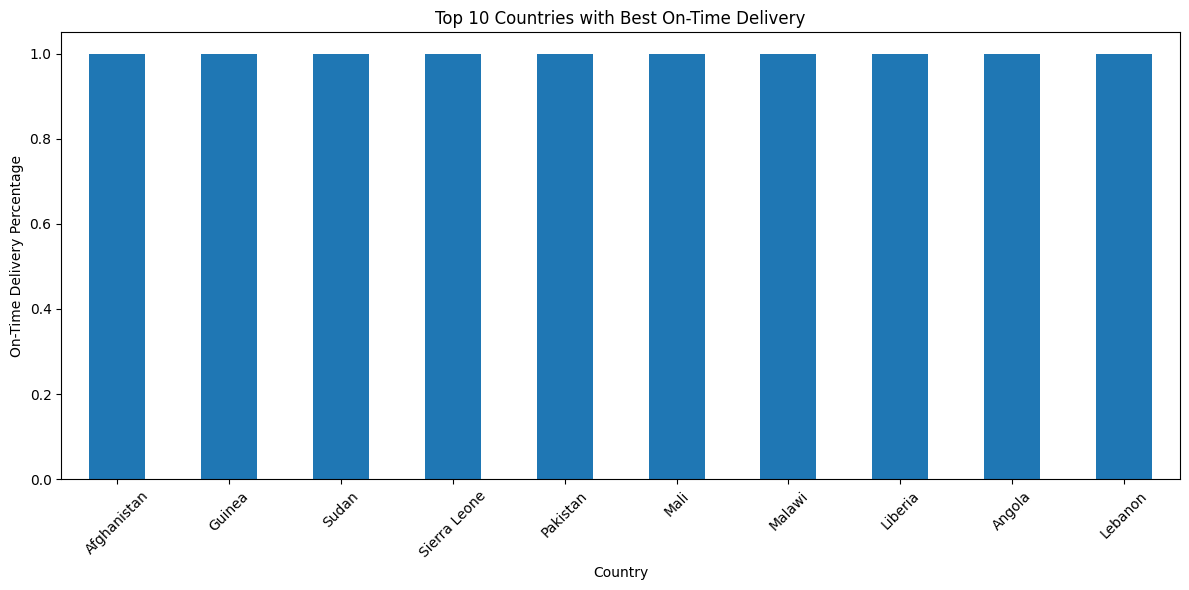

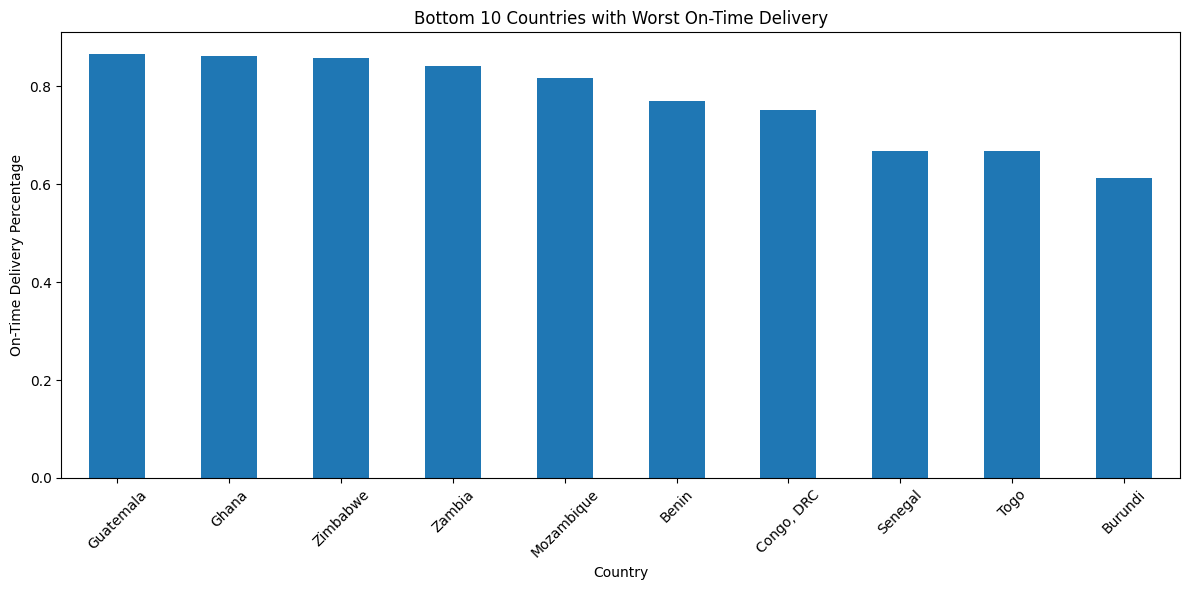

In [17]:
# Top 10 countries with the best on-time delivery
top_10_countries = country_performance.head(10)

# Bottom 10 countries with the worst on-time delivery
bottom_10_countries = country_performance.tail(10)

# Plotting top 10 countries
plt.figure(figsize=(12, 6))
top_10_countries.plot(kind='bar')
plt.title('Top 10 Countries with Best On-Time Delivery')
plt.xlabel('Country')
plt.ylabel('On-Time Delivery Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting bottom 10 countries
plt.figure(figsize=(12, 6))
bottom_10_countries.plot(kind='bar')
plt.title('Bottom 10 Countries with Worst On-Time Delivery')
plt.xlabel('Country')
plt.ylabel('On-Time Delivery Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Va. Cost of Missed On-Time Deliveries

In [18]:
# Convert 'freight cost (usd)' to numeric, replacing non-numeric values with NaN
df['freight cost (usd)'] = pd.to_numeric(df['freight cost (usd)'], errors='coerce')

# Calculate the cost of missing on-time delivery
late_deliveries = df[~df['on_time']]

# Calculate total cost of late deliveries
late_delivery_cost = late_deliveries['freight cost (usd)'].sum()

# Calculate average cost of late deliveries
average_late_delivery_cost = late_deliveries['freight cost (usd)'].mean()

print(f"Total cost of missing on-time delivery: ${late_delivery_cost:,.2f}")
print(f"Average cost of missing on-time delivery per shipment: ${average_late_delivery_cost:,.2f}")

# Create 'on_time' column to determine if deliveries were on time
df_cleaned['on_time'] = df_cleaned['delivered to client date'] <= df_cleaned['scheduled delivery date']

# Calculate the cost of missing on-time delivery
late_deliveries = df_cleaned[~df_cleaned['on_time']]

# Calculate total and average cost of late deliveries
late_delivery_cost = late_deliveries['freight cost (usd)'].sum()
average_late_delivery_cost = late_deliveries['freight cost (usd)'].mean()

# Additional analysis
total_shipments = len(df_cleaned)
late_shipments = len(late_deliveries)
on_time_percentage = (total_shipments - late_shipments) / total_shipments * 100

print("Total shipments: " + str(total_shipments))
print("Late shipments: " + str(late_shipments))
print("On-time delivery percentage: " + str(on_time_percentage) + "%")

# Additional analysis
total_shipments = len(df)
late_shipments = len(late_deliveries)
on_time_percentage = (total_shipments - late_shipments) / total_shipments * 100

# Top 5 countries with highest late delivery costs
top_5_late_cost_countries = late_deliveries.groupby('country')['freight cost (usd)'].sum().sort_values(ascending=False).head()

Total cost of missing on-time delivery: $9,788,117.90
Average cost of missing on-time delivery per shipment: $13,156.07
Total shipments: 10324
Late shipments: 1632
On-time delivery percentage: 84.19217357613327%


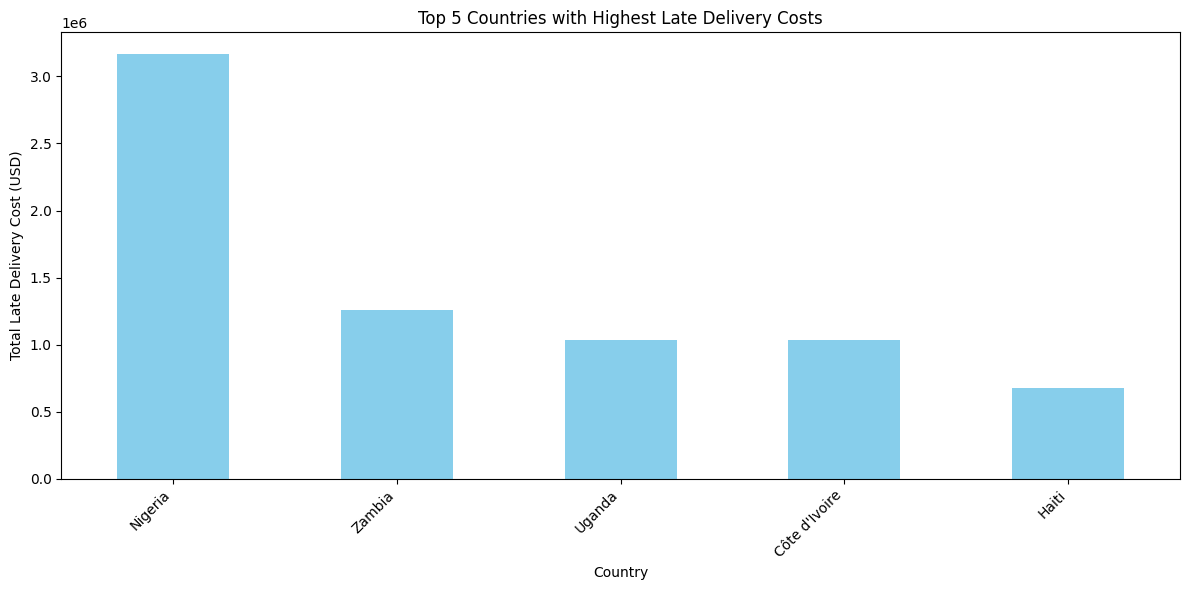

In [19]:
# 1. Top 5 countries with highest late delivery costs
plt.figure(figsize=(12, 6))
top_5_late_cost_countries.plot(kind='bar', color='skyblue')
plt.title('Top 5 Countries with Highest Late Delivery Costs')
plt.xlabel('Country')
plt.ylabel('Total Late Delivery Cost (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


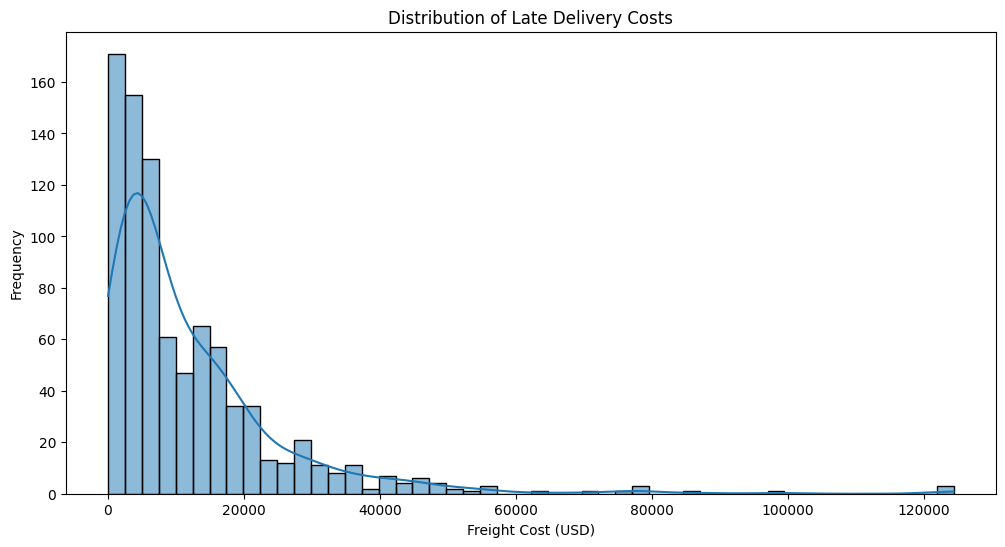

In [20]:
# 2. Late Delivery Cost Distribution
plt.figure(figsize=(12, 6))
sns.histplot(late_deliveries['freight cost (usd)'], bins=50, kde=True)
plt.title('Distribution of Late Delivery Costs')
plt.xlabel('Freight Cost (USD)')
plt.ylabel('Frequency')
plt.show()

The distribution is right-skewed, indicating that most late delivery costs are on the lower end, with a few high-cost outliers.

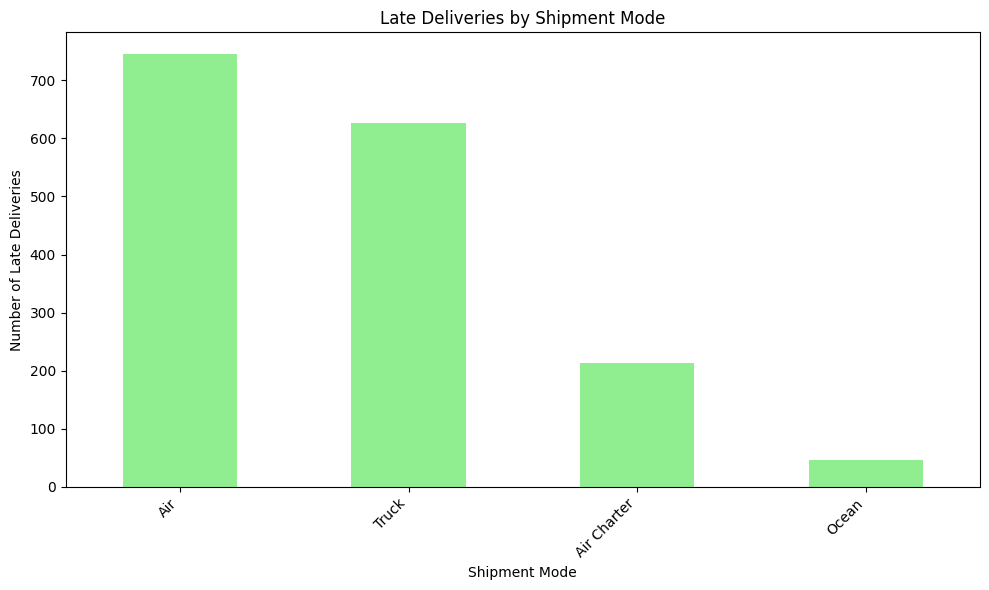

In [21]:
# 3. Late Deliveries by Shipment Mode
late_by_mode = late_deliveries['shipment mode'].value_counts()
plt.figure(figsize=(10, 6))
late_by_mode.plot(kind='bar', color='lightgreen')
plt.title('Late Deliveries by Shipment Mode')
plt.xlabel('Shipment Mode')
plt.ylabel('Number of Late Deliveries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Vb. Key Observations:

* **Total shipments: 10324**

* **Late shipments: 1632**

* **Total cost of missing on-time delivery: $9,788,117.90**

* **Average cost of missing on-time delivery per shipment: $13,156.07**

* **Nigeria incurs the highest costs due to late shipments.**

# Vc. Demand Analysis on selected countries (Nigeria, Zambia, Côte d'Ivoire, South Africa) 

In [22]:
# Define 'df_filtered' by filtering the loaded data for the specified countries
countries_of_interest = ['Nigeria', 'Zambia', 'South Africa', "C\u00f4te d'Ivoire"]
df_filtered = df[df['country'].isin(countries_of_interest)]

# Display the first few rows of df_filtered to verify
print(df_filtered.head())
print("\
Shape of df_filtered:", df_filtered.shape)

   id project code            pq # po / so # asn/dn #        country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
2   4   100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire   
5  23   112-NG-T01  Pre-PQ Process   SCMS-87   ASN-57        Nigeria   
6  44   110-ZM-T01  Pre-PQ Process  SCMS-139  ASN-130         Zambia   
8  46   112-NG-T01  Pre-PQ Process  SCMS-156   ASN-93        Nigeria   

  managed by  fulfill via vendor inco term shipment mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
2   PMO - US  Direct Drop              FCA           Air  ...   
5   PMO - US  Direct Drop              EXW           Air  ...   
6   PMO - US  Direct Drop              DDU           Air  ...   
8   PMO - US  Direct Drop              EXW           Air  ...   

  line item quantity line item value pack price unit price  \
0                 19          551.00      29.00       0.97   
2                500        40000.00      80.00     

In [23]:
# Analyze Demand
demand_by_country = df_filtered.groupby('country')['line item quantity'].sum().sort_values(ascending=False)

print("Demand by Country:")
print(demand_by_country)

# Analyze Profit Margin
df_filtered['freight cost (usd)'] = pd.to_numeric(df_filtered['freight cost (usd)'], errors='coerce')
df_filtered['line item insurance (usd)'] = pd.to_numeric(df_filtered['line item insurance (usd)'], errors='coerce')
df_filtered['total_cost'] = df_filtered['freight cost (usd)'] + df_filtered['line item insurance (usd)']

value_cost_by_country = df_filtered.groupby('country').agg({
    'line item value': 'sum',
    'total_cost': 'sum'
}).reset_index()

value_cost_by_country['profit_margin'] = (value_cost_by_country['line item value'] - value_cost_by_country['total_cost']) / value_cost_by_country['line item value']

print("\
Profit Margin by Country:")
print(value_cost_by_country.sort_values('profit_margin', ascending=False))

# Score based on demand and profit margin
combined_metrics = pd.merge(demand_by_country.reset_index(), value_cost_by_country, on='country')
combined_metrics['score'] = combined_metrics['line item quantity'] * combined_metrics['profit_margin']

print("\
Combined Metrics (sorted by score):")
print(combined_metrics.sort_values('score', ascending=False))

# Select top 3 locations based on the combined score
top_3_locations = combined_metrics.sort_values('score', ascending=False).head(3)

print("\
Top 3 Recommended Warehouse Locations:")
print(top_3_locations[['country', 'line item quantity', 'profit_margin', 'score']])

Demand by Country:
country
Nigeria          33967950
Zambia           28627539
South Africa     22995781
Côte d'Ivoire    11898572
Name: line item quantity, dtype: int64
Profit Margin by Country:
         country  line item value   total_cost  profit_margin
2   South Africa     1.086701e+08   2660005.86       0.975522
3         Zambia     2.469888e+08   6589065.44       0.973322
1        Nigeria     3.502721e+08  14649119.84       0.958178
0  Côte d'Ivoire     1.208845e+08   6213927.92       0.948596
Combined Metrics (sorted by score):
         country  line item quantity  line item value   total_cost  \
0        Nigeria            33967950     3.502721e+08  14649119.84   
1         Zambia            28627539     2.469888e+08   6589065.44   
2   South Africa            22995781     1.086701e+08   2660005.86   
3  Côte d'Ivoire            11898572     1.208845e+08   6213927.92   

   profit_margin         score  
0       0.958178  3.254734e+07  
1       0.973322  2.786383e+07  
2       

/tmp/ipykernel_17/1373605929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['freight cost (usd)'] = pd.to_numeric(df_filtered['freight cost (usd)'], errors='coerce')
/tmp/ipykernel_17/1373605929.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['line item insurance (usd)'] = pd.to_numeric(df_filtered['line item insurance (usd)'], errors='coerce')
/tmp/ipykernel_17/1373605929.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

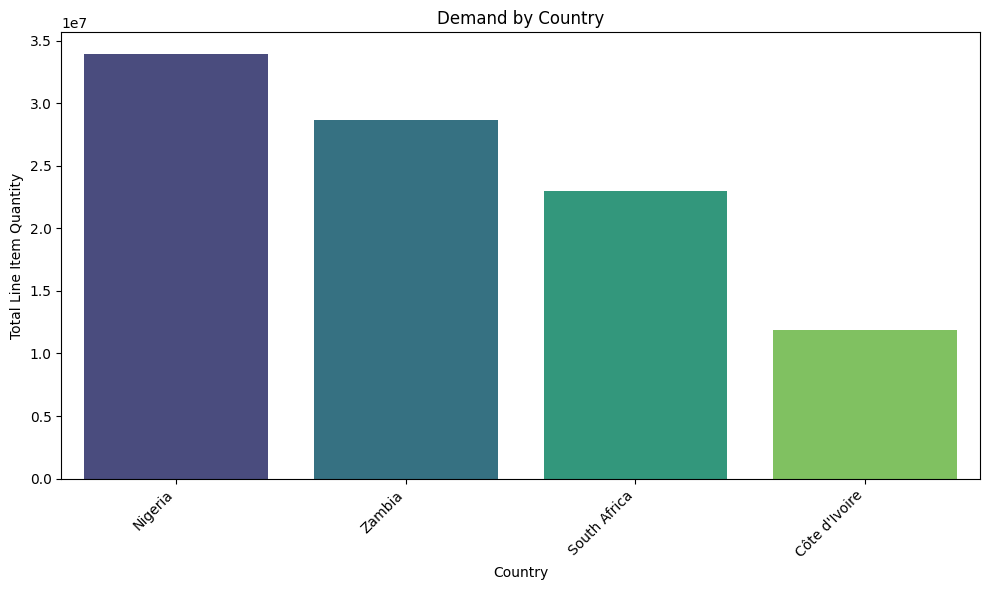

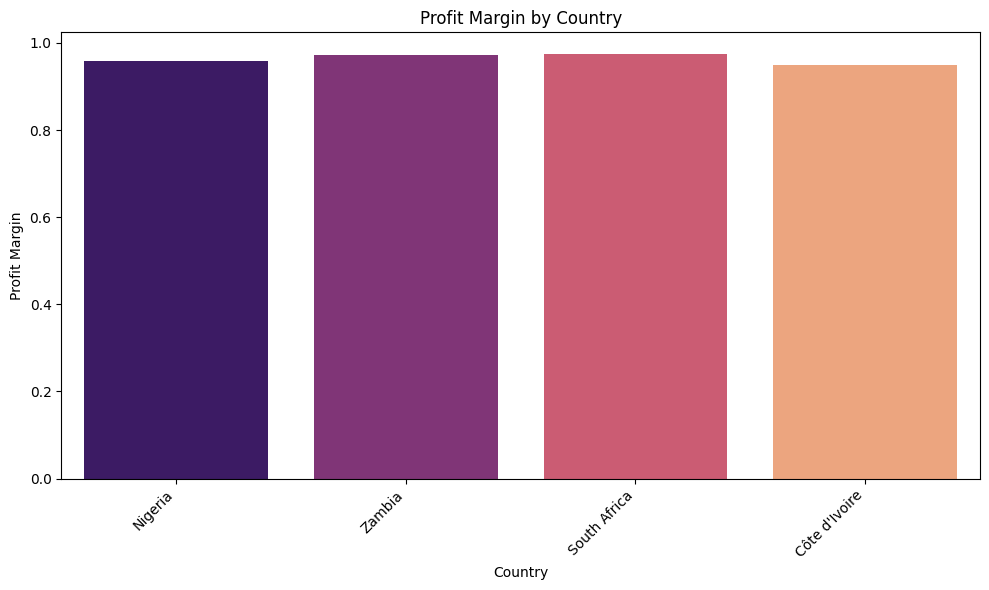

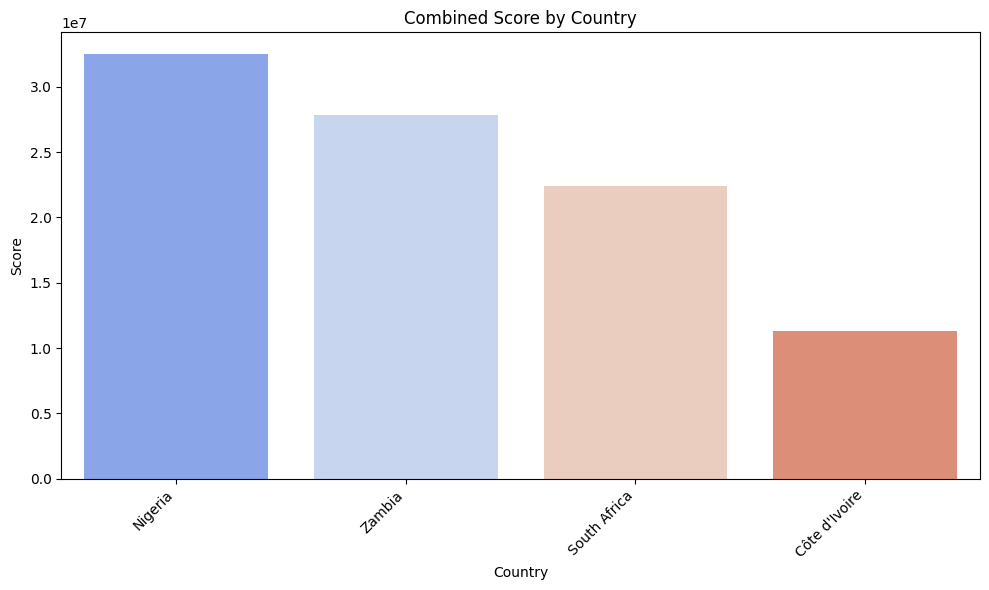

In [24]:
# Create a barplot for demand by country
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_metrics['country'], y=combined_metrics['line item quantity'], palette='viridis')
plt.title('Demand by Country')
plt.xlabel('Country')
plt.ylabel('Total Line Item Quantity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a barplot for profit margin by country
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_metrics['country'], y=combined_metrics['profit_margin'], palette='magma')
plt.title('Profit Margin by Country')
plt.xlabel('Country')
plt.ylabel('Profit Margin')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a barplot for combined score by country
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_metrics['country'], y=combined_metrics['score'], palette='coolwarm')
plt.title('Combined Score by Country')
plt.xlabel('Country')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Vd. Key Observations:

**Demand by Country**

* Nigeria leads with the highest demand of 33,967,950 line items.
* Zambia follows closely with 28,627,539 line items.
* South Africa holds a substantial demand with 22,995,781 line items.
* Côte d'Ivoire has the lowest demand among the four countries, totaling 11,898,572 line items.

**Profit Margin by Country**

* All four countries exhibit high profit margins, all above 94%.
* South Africa boasts the highest profit margin at 97.55%.
* Zambia closely follows with a 97.44% profit margin.
* Nigeria maintains a 95.85% profit margin.
* Côte d'Ivoire, with the lowest profit margin of the four, holds at 94.97%.

**Combined Scores by Country**

* The score is calculated by multiplying the line item quantity (demand) by the profit margin.
* Nigeria secures the highest score due to its significant demand, despite having a slightly lower profit margin compared to South Africa and Zambia.
* Following, Zambia demonstrates a strong balance of high demand and high profit margin.
* South Africa ranks third, driven by its high-profit margin despite lower demand.
* Côte d'Ivoire ranks lowest due to its lower demand, resulting in the lowest score.

# VI. Summary of Analysis

1. **Nigeria:**

* Demand: Nigeria leads with the highest demand of 33,967,950 line items. 

* Profit Margin: Nigeria boasts a robust profit margin of 95.85%.

* Total Shipping Cost: Approximately $16.79 million.

* Shipping Demand: 1,194 shipments.


2. **South Africa:**

* Demand: South Africa commands asubstantial demand of 22,995,781 line items.

* Profit Margin: South Africa boasts the highest profit margin at 97.55%.

* Total Shipping Cost: Approximately $9.05 million.

* Shipping Demand: 1,406 shipments, the highest among the countries.


3. **Côte d'Ivoire:**

* Demand: Côte d'Ivoire has the lowest demand among the four countries with 11,898,572 line items.

* Profit Margin: Côte d'Ivoire maintains a profit margin of 94.97%.

* Total Shipping Cost: Approximately $8.17 million.

* Shipping Demand: 1,083 shipments.


4. **Zambia:**

* Demand: Zambia closely follows with 28,627,539 line items.

* Profit Margin: Zambia holds a competitive profit margin of 97.44%.

* Total Shipping Cost: Approximately $6.31 million.

* Shipping Demand: 87 shipments.


# VII. Predictive Analysis:

In [25]:
# Calculate the current total freight costs for Nigeria, South Africa, and Côte d'Ivoire
countries_for_warehouses = ['Nigeria', 'South Africa', "Côte d'Ivoire"]
current_freight_costs = df[df['country'].isin(countries_for_warehouses)]['freight cost (usd)'].sum()

# Convert 'freight cost (usd)' to numeric for the relevant countries
df['freight cost (usd)'] = pd.to_numeric(df['freight cost (usd)'], errors='coerce')

# Recalculate the current total freight costs for Nigeria, South Africa, and Côte d'Ivoire
current_freight_costs = df[df['country'].isin(countries_for_warehouses)]['freight cost (usd)'].sum()

# Calculate the reduced freight costs assuming a 30% reduction
reduced_freight_costs = current_freight_costs * 0.7

# Calculate the annual cost savings
annual_cost_savings = current_freight_costs - reduced_freight_costs

print("Current Total Freight Costs: $", round(current_freight_costs, 2))
print("Reduced Total Freight Costs (30% reduction): $", round(reduced_freight_costs, 2))
print("Annual Cost Savings: $", round(annual_cost_savings, 2))

Current Total Freight Costs: $ 22854303.2
Reduced Total Freight Costs (30% reduction): $ 15998012.24
Annual Cost Savings: $ 6856290.96


<Figure size 1200x600 with 0 Axes>

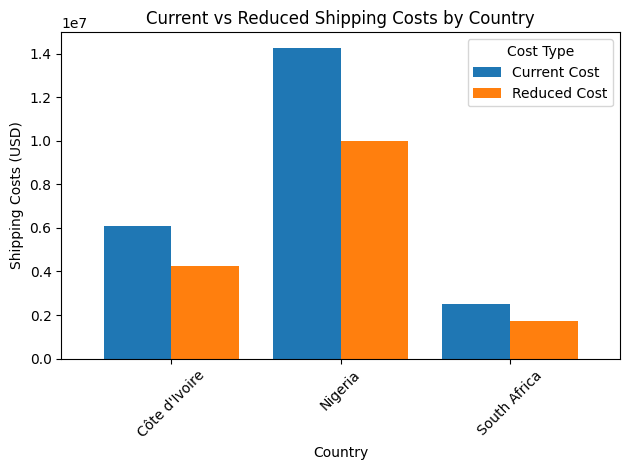

In [26]:
# Calculate current and reduced costs for each country
countries_for_warehouses = ['Nigeria', 'South Africa', "C\u00f4te d'Ivoire"]
current_costs = df[df['country'].isin(countries_for_warehouses)].groupby('country')['freight cost (usd)'].sum()
reduced_costs = current_costs * 0.7

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Current Cost': current_costs,
    'Reduced Cost': reduced_costs
})

# Create the bar chart
plt.figure(figsize=(12, 6))
plot_data.plot(kind='bar', width=0.8)
plt.title('Current vs Reduced Shipping Costs by Country')
plt.xlabel('Country')
plt.ylabel('Shipping Costs (USD)')
plt.legend(title='Cost Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# VIIb. Key Observations:

Establishing warehouses in Nigeria, South Africa, and Côte d'Ivoire, with an assumed 30% reduction in freight costs due to optimized warehouse locations, is projected to result in an annual cost savings of approximately $ 6,856,290.96.

This would lead to a reduced total cost of $ 15,998,012.24, compared to the current total cost of $ 22,854,303.20.

# Recommendations:

Overall, the US government is losing on average $13,156.07 per shipment due to late deliveries. To address this issue, the US government must focus on improving timely delivery. The suggested method is by establishing warehouse locations in strategic countries in Africa.


1. Primary Warehouse Location: 

**Nigeria:**

Rationale: Nigeria has high demand and shipping costs. Establishing a warehouse in Nigeria would undeniably reduce shipping costs and enhance service efficiency due to its strategic position in West Africa and North Africa.

Benefits:
- Substantial reduction in average shipping costs.
- Swift response times to high-demand areas.
- Centralized location to effectively serve multiple surrounding countries.

Next Step: Given the high shipping costs, it is crucial to explore opportunities to optimize shipping routes, negotiate better rates, or consolidate shipments.

2. Secondary Warehouse Location: 

**South Africa:**

Rationale: South Africa boasts the highest shipment count, signifying notable demand. It functions as a pivotal logistical hub for southern Africa and can efficiently support operations in neighbouring countries (Central Africa).

Benefits:
- Serves as a pivotal hub for southern Africa
- Possesses established infrastructure for logistics and distribution
- Balances the network by effectively covering southern regions

Next Steps: With the highest shipping demand, it is imperative to ensure that logistics operations are efficient and scalable to handle the volume.

3. Supplementary Location:

**Côte d'Ivoire:**

Rationale: Côte d'Ivoire stands as a significant destination with high demand. It can serve as a regional distribution center for West Africa, supporting Nigeria and other neighboring countries.

Benefits:
- Augmented service capabilities in West Africa
- Decreases burden on the Nigerian warehouse
- Provides redundancy and resilience in the supply chain network

Establish warehouses in Nigeria, Côte d'Ivoire, and South Africa to proficiently serve the areas with the highest demand.

Next Step: Despite lower costs, continuous monitoring is imperative to ensure that service levels remain high and costs do not escalate.

# Next Steps:

- It is crucial to focus on improving supply chain efficiency in the recommended locations, potentially through local partnerships or improved logistics networks.
- There is a need to monitor the performance of these warehouses regularly and adjust strategies as needed to maintain cost savings and meet demand effectively.
- A comprehensive analysis of transportation routes and local infrastructure should be conducted to further optimize the exact locations within these countries.
- It is imperative to implement a robust inventory management system to ensure optimal stock levels at each warehouse, balancing between meeting demand and minimizing holding costs.

By implementing these recommendations, the US government can significantly reduce shipping costs while improving service to areas with the highest demand.